In [1]:
    !mkdir -p /kaggle/working/all_images
    !cp ../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/* /kaggle/working/all_images/
    !cp ../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/* /kaggle/working/all_images/

In [2]:
# ================== IMPORTS ==================
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50

2025-06-07 16:57:09.306324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749315429.524627      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749315429.588188      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ================== MODEL ARCHITECTURE ==================
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
# Create the model with the ResNet50 base model
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))


I0000 00:00:1749315443.259536      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
data = pd.read_csv("../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
data['image_full_name'] = data['image_id'] + '.jpg'
X = data[['image_full_name','dx','lesion_id']]

print(data.head())  # To check the data structure and ensure 'dx' is present


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

    image_full_name  
0  ISIC_0027419.jpg  
1  ISIC_0025030.jpg  
2  ISIC_0026769.jpg  
3  ISIC_0025661.jpg  
4  ISIC_0031633.jpg  


In [5]:
# Include 'dx' in the X DataFrame
X = data[['image_full_name', 'lesion_id', 'dx']]

# Train/Validation/Test split
Y = X.pop('dx').to_frame()  # Now 'dx' will be available to pop
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.17, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42)




In [6]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)


# train = pd.concat([X_train, y_train], axis=1)
# val = pd.concat([X_val, y_val], axis=1)
# test = pd.concat([X_test, y_test], axis=1)



In [7]:
# Label Encoding for evaluation
encoder = LabelEncoder()
encoder.fit(val['dx'])
val['label'] = encoder.transform(val['dx'])
encoder.fit(test['dx'])
test['label'] = encoder.transform(test['dx'])
name_as_indexes_test = test['label'].values

In [8]:

# ======== TRAIN DATA GENERATOR (With Augmentation) ==========
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=10, zoom_range=0.1,
                                     width_shift_range=0.0, height_shift_range=0.00)
train_data = train_generator.flow_from_dataframe(
    dataframe=train, x_col="image_full_name", y_col="dx",
    directory="/kaggle/working/all_images",
    batch_size=32, shuffle=True, class_mode="categorical", target_size=(224, 224))

# ======== VALIDATION & TEST GENERATORS (NO Augmentation) ==========
val_generator = ImageDataGenerator(rescale=1./255)

val_data = val_generator.flow_from_dataframe(
    dataframe=val,
    x_col="image_full_name",
    y_col="dx",
    directory="/kaggle/working/all_images",
    batch_size=64,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

test_data = val_generator.flow_from_dataframe(
    dataframe=test,
    x_col="image_full_name",
    y_col="dx",  
    directory="/kaggle/working/all_images",
    shuffle=False,
    batch_size=1,
    class_mode=None,
    target_size=(224, 224)
)


Found 6898 validated image filenames belonging to 7 classes.
Found 1414 validated image filenames belonging to 7 classes.
Found 1703 validated image filenames.


In [9]:
# ================== TRAINING ==================
learning_control = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])



In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=8,
    verbose=1,
    callbacks=[learning_control, early_stop]
)


Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749315551.472772      94 service.cc:148] XLA service 0x7a2f60003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749315551.473785      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749315556.076401      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/216 ━━━━━━━━━━━━━━━━━━━━ 4:37:20 77s/step - accuracy: 0.1250 - loss: 6.9047

I0000 00:00:1749315576.883177      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/216 ━━━━━━━━━━━━━━━━━━━━ 210s 615ms/step - accuracy: 0.6022 - loss: 1.5930 - val_accuracy: 0.6719 - val_loss: 2.1145 - learning_rate: 1.0000e-04
Epoch 2/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 107s 479ms/step - accuracy: 0.7113 - loss: 0.8054 - val_accuracy: 0.6584 - val_loss: 1.2660 - learning_rate: 1.0000e-04
Epoch 3/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 474ms/step - accuracy: 0.7774 - loss: 0.6290 - val_accuracy: 0.6719 - val_loss: 1.6324 - learning_rate: 1.0000e-04
Epoch 4/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 476ms/step - accuracy: 0.8081 - loss: 0.5387 - val_accuracy: 0.6719 - val_loss: 2.7636 - learning_rate: 1.0000e-04
Epoch 5/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 476ms/step - accuracy: 0.8339 - loss: 0.4676 - val_accuracy: 0.7270 - val_loss: 1.1130 - learning_rate: 1.0000e-04
Epoch 6/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 477ms/step - accuracy: 0.8493 - loss: 0.4278 - val_accuracy: 0.8083 - val_loss: 0.6062 - learning_rate: 1.0000e-04
Epoch 7/8
216/216 ━━━━━━━━━━━━━━━━━━━━ 109s 491ms/step -

1704/1704 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Accuracy: 81.73810921902525
              precision    recall  f1-score   support

           0       0.69      0.47      0.56        62
           1       0.69      0.79      0.74        77
           2       0.69      0.56      0.62       201
           3       0.57      0.33      0.42        24
           4       0.52      0.71      0.60       191
           5       0.92      0.91      0.92      1128
           6       0.91      1.00      0.95        20

    accuracy                           0.82      1703
   macro avg       0.71      0.68      0.69      1703
weighted avg       0.83      0.82      0.82      1703



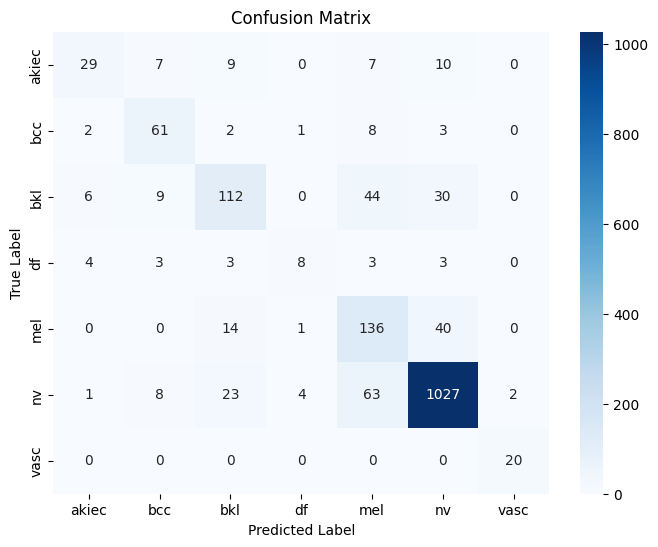

In [11]:

# ================== RESET & PREDICT ==================
test_data.reset()

predictions = model.predict(
    test_data,
    steps=test_data.samples // test_data.batch_size + 1,
    verbose=1
)

# Get predicted class indices
y_pred = np.argmax(predictions, axis=1)

# ================== ACCURACY & CLASSIFICATION REPORT ==================
correct = np.where(y_pred == name_as_indexes_test)
accuracy = (np.count_nonzero(correct) / len(name_as_indexes_test)) * 100
print("Test Accuracy:", accuracy)
print(classification_report(name_as_indexes_test, y_pred))

# ================== CONFUSION MATRIX ==================
# Use class_indices from a generator that has it (train_data or val_data)
class_names = list(train_data.class_indices.keys())  # or val_data.class_indices.keys()

# Compute confusion matrix
cm = confusion_matrix(name_as_indexes_test, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [12]:
model.save("/kaggle/working/Final_ResNetHamModel.h5")  # Save the model to the appropriate location


In [20]:
from IPython.display import FileLink

FileLink(r'Final_ResNetHamModel.h5')


/kaggle/working/Final_ResNetHamModel.h5

Found 12 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Classification Report:

              precision    recall  f1-score   support

         bcc       1.00      1.00      1.00         1
         bkl       0.00      0.00      0.00         1
          nv       0.89      0.80      0.84        10

   micro avg       0.90      0.75      0.82        12
   macro avg       0.63      0.60      0.61        12
weighted avg       0.82      0.75      0.79        12



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


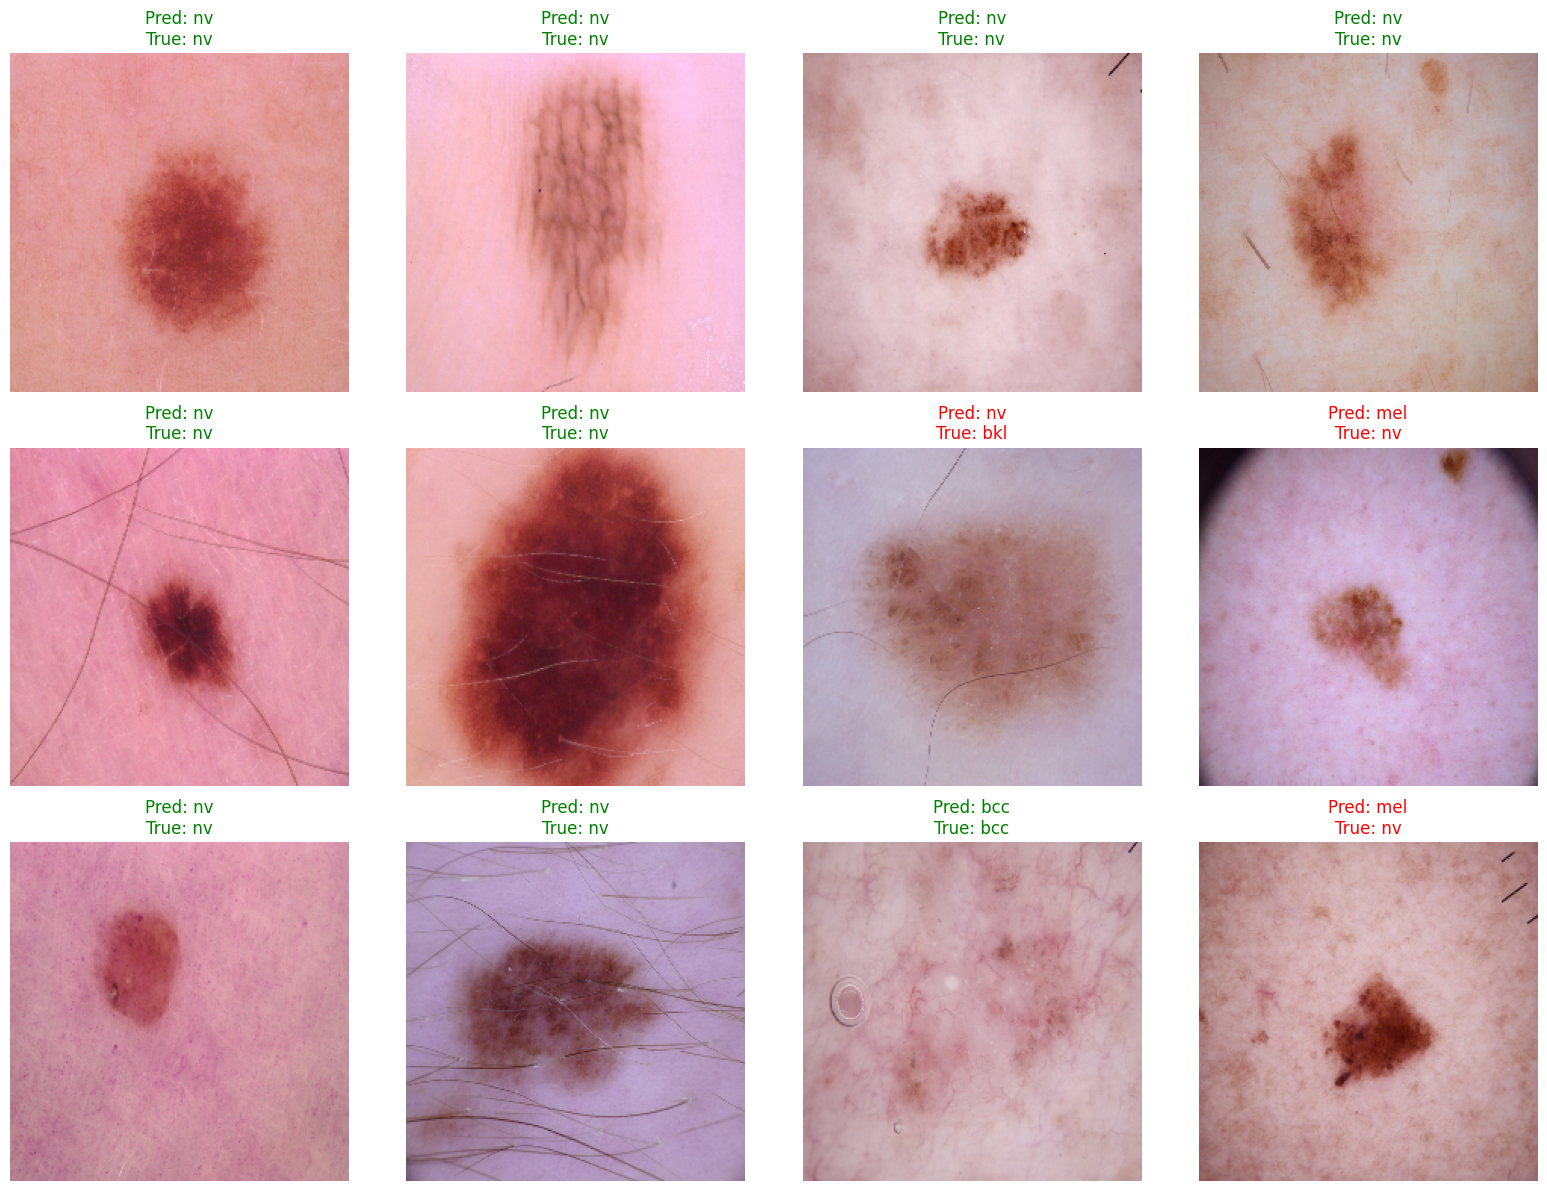

In [25]:


# === STEP 1: Sample test images ===
sample_size = 12  # Only sample 12 images
test_sampled = test.sample(n=sample_size, random_state=42).reset_index(drop=True)


# === STEP 2: Prepare data generator for sampled test data ===
test_gen = ImageDataGenerator(rescale=1./255)

test_generator_sample = test_gen.flow_from_dataframe(
    dataframe=test_sampled,
    x_col="image_full_name",
    y_col="dx",
    directory="/kaggle/working/all_images",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode="categorical"
)

# === STEP 3: Predict ===
predictions = model.predict(test_generator_sample, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = encoder.transform(test_sampled['dx'].values)

# === STEP 4: Evaluation ===
unique_labels = np.unique(true_classes)
class_names = encoder.inverse_transform(unique_labels)
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, labels=unique_labels, target_names=class_names))

# === STEP 5: Plot predictions (12 images) ===
num_images_to_plot = min(12, len(test_sampled))

plt.figure(figsize=(16, 12))
for i in range(num_images_to_plot):
    img_path = os.path.join("/kaggle/working/all_images", test_sampled.iloc[i]['image_full_name'])
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0

    plt.subplot(3, 4, i + 1)
    plt.imshow(img_array)
    pred_label = encoder.classes_[predicted_classes[i]]
    true_label = encoder.classes_[true_classes[i]]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 32.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 101.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.1 MB/s eta 0:00:00


In [24]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load your trained model
model = load_model("/kaggle/working/Final_ResNetHamModel.h5")  # adjust path

# Define class names (if applicable)
class_names = ['Actinic keratoses', 'Basal cell carcinoma','Benign keratosis-like lesions', 'Dermatofibroma','Melanoma', 'Melanocytic nevi','Vascular lesions']  # replace with your own labels

# Preprocessing and prediction
def predict(img: Image.Image):
    img = img.resize((224, 224))  # Adjust to your model's input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    pred = model.predict(img_array)
    result = class_names[np.argmax(pred)]
    confidence = float(np.max(pred))
    return f"{result} ({confidence:.2%} confidence)"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Skin Cancer classifier",
    description="Upload an image to get predictions from the trained model"
)

interface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://086747d056e2bea01c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
